In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import argparse
import numpy as np
from tensorflow import keras

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [3]:
def load_pep_and_codify(file, max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,'L':11,'K':12,'M':13,'F':14,
        'P':15,'O':16,'S':17,'U':18,'T':19,'W':20,'Y':21,'V':22}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
    pep_codes=[]
    long_pep_counter = 0
    newLines = []
    for pep in lines:
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(current_pep)
            newLines.extend([pep])
        else:
            long_pep_counter += 1
    predict_data = keras.preprocessing.sequence.pad_sequences(pep_codes, value=0, padding='post', maxlen=max_len)
    return predict_data, long_pep_counter, newLines

# New Train

In [4]:
model = tf.keras.Sequential([
    # vacabulary size 23 (22 AminoAcid + zero padding)
    # embedding vector size 50
    # input length (including padding) 30 ( 81 to 30)
    tf.keras.layers.Embedding(23, 50, input_length=30),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same'),
#     tf.keras.layers.Conv1D(filters=64, kernel_size=2, strides=1),
    
    tf.keras.layers.LSTM(128),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(np.random.uniform(0, 0.2)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            1150      
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 128)           19328     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

# 1. Make Data X_train, y_train, X_test, y_test

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = '../compareModel/2019Bioinformatics_DeepMSPeptide/DeepMSPeptide/'

In [8]:
# make DeepMSpeptide format
df_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm.csv')
df_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm.csv')

inp = open(file_path+'detect_peptide_train_noptm.txt', 'w')
inp_y = open(file_path+'detect_peptide_train_noptm_y.txt', 'w')
for x, y in df_peptide_train[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

inp = open(file_path+'detect_peptide_test_noptm.txt', 'w')
inp_y = open(file_path+'detect_peptide_test_noptm_y.txt', 'w')
for x, y in df_peptide_test[['PEP', 'ID']].values:
    inp.write(x+'\n')
    inp_y.write(str(y)+'\n')
inp.close()
inp_y.close()

args = file_path + 'detect_peptide_train_noptm.txt'
print('Loading input peptides')
X_train, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_train_noptm_y.txt')
y_train = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

args = file_path + 'detect_peptide_test_noptm.txt'
print('Loading input peptides')
X_test, skipped, lines = load_pep_and_codify(args, 30)
tmp = open(file_path+'detect_peptide_test_noptm_y.txt')
y_test = np.array([int(_.replace('\n', '')) for _ in tmp.readlines()])
tmp.close()
print('Succesfully loaded {0} peptides and skipped {1}'.format(len(lines), str(skipped)))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)


Loading input peptides
Succesfully loaded 177997 peptides and skipped 0
Loading input peptides
Succesfully loaded 44499 peptides and skipped 0
(142397, 30) (35600, 30) (44499, 30) (142397,) (35600,) (44499,)


# 2. train

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [10]:
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=100,
                    validation_data=(X_val, y_val),
                                       callbacks=[es])

Epoch 1/200
1424/1424 [==============================] - 14s 7ms/step - loss: 0.5341 - accuracy: 0.7118 - val_loss: 0.3790 - val_accuracy: 0.8259
Epoch 2/200
1424/1424 [==============================] - 9s 6ms/step - loss: 0.3854 - accuracy: 0.8188 - val_loss: 0.3720 - val_accuracy: 0.8275
Epoch 3/200
1424/1424 [==============================] - 9s 6ms/step - loss: 0.3699 - accuracy: 0.8289 - val_loss: 0.3576 - val_accuracy: 0.8360
Epoch 4/200
1424/1424 [==============================] - 9s 6ms/step - loss: 0.3597 - accuracy: 0.8364 - val_loss: 0.3549 - val_accuracy: 0.8385
Epoch 5/200
1424/1424 [==============================] - 9s 6ms/step - loss: 0.3553 - accuracy: 0.8376 - val_loss: 0.3447 - val_accuracy: 0.8441
Epoch 6/200
1424/1424 [==============================] - 9s 6ms/step - loss: 0.3445 - accuracy: 0.8425 - val_loss: 0.3394 - val_accuracy: 0.8479
Epoch 7/200
1424/1424 [==============================] - 9s 6ms/step - loss: 0.3420 - accuracy: 0.8447 - val_loss: 0.3363 - val_a

Epoch 57/200
1424/1424 [==============================] - 10s 7ms/step - loss: 0.2928 - accuracy: 0.8737 - val_loss: 0.3002 - val_accuracy: 0.8701
Epoch 58/200
1424/1424 [==============================] - 10s 7ms/step - loss: 0.2944 - accuracy: 0.8732 - val_loss: 0.3016 - val_accuracy: 0.8696
Epoch 59/200
1424/1424 [==============================] - 10s 7ms/step - loss: 0.2921 - accuracy: 0.8744 - val_loss: 0.3005 - val_accuracy: 0.8710
Epoch 60/200
1424/1424 [==============================] - 10s 7ms/step - loss: 0.2930 - accuracy: 0.8730 - val_loss: 0.3002 - val_accuracy: 0.8708
Epoch 61/200
1424/1424 [==============================] - 11s 8ms/step - loss: 0.2910 - accuracy: 0.8749 - val_loss: 0.2993 - val_accuracy: 0.8715
Epoch 62/200
1424/1424 [==============================] - 10s 7ms/step - loss: 0.2940 - accuracy: 0.8729 - val_loss: 0.3036 - val_accuracy: 0.8682
Epoch 63/200
1424/1424 [==============================] - 10s 7ms/step - loss: 0.2910 - accuracy: 0.8750 - val_loss: 0

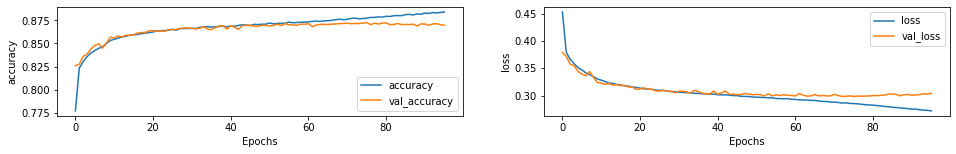

In [11]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# 3. test

In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

1391/1391 [==============================] - 5s 3ms/step - loss: 0.3051 - accuracy: 0.8693
Test Loss: 0.30513545870780945
Test Accuracy: 0.8692554831504822


              precision    recall  f1-score   support

           0       0.89      0.84      0.87     22330
           1       0.85      0.90      0.87     22169

    accuracy                           0.87     44499
   macro avg       0.87      0.87      0.87     44499
weighted avg       0.87      0.87      0.87     44499

rf auc : 0.9426934711949047


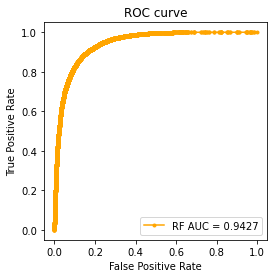

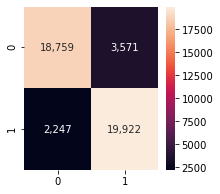

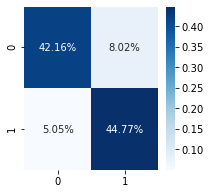

In [14]:
# prediction
y_pred = [1 if i>=0.5 else 0 for i in model.predict(X_test)]
print(classification_report(y_test, y_pred))
# AUC
probs = model.predict(X_test)
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()